In [26]:
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Grad-CAM

In [3]:
with open("/content/drive/MyDrive/深度學習期末專題/model/model_EfficientNetB3_01.config", "r") as text_file:
    json_string = text_file.read()
model2 = keras.models.model_from_json(json_string)
model2.load_weights("/content/drive/MyDrive/深度學習期末專題/model/best_model_EfficientNetB3(0.831).h5")

In [4]:
# 來找出要觀察的卷積層名稱
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

設定卷積層的名稱與圖片路徑

In [17]:
IMG_PATH = '/content/drive/MyDrive/深度學習期末專題/grad-cam/0t_nv.jpg'
LAYER_NAME = 'block5d_expand_conv' 
lookup_lables={ 0:'nv', 1:'akiec', 2:'mel', 3:'df', 4:'bcc', 5:'vasc', 6:'bkl'}
CLASS_INDEX = 0  #CLASS_INDEX = 0 ～　6 

對影像進行對應的前處理

In [18]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
import tensorflow as tf
#讀取影像並縮放為模型input的大小
img = tf.keras.preprocessing.image.load_img( IMG_PATH, target_size=(224, 224) )
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.array([img])  # Convert single image to a batch.
#把影像進行對應的前處理
img = preprocess_input(img)

In [19]:
#取得影像分類名字
lookup_lables={ 0:'nv', 1:'akiec', 2:'mel', 3:'df', 4:'bcc', 5:'vasc', 6:'bkl'}
preds = model2.predict(img)
# print(preds)
pred_class = np.argmax(preds[0])
print(pred_class)
pred_class_name = lookup_lables[pred_class]
print(pred_class_name)

0
nv


建立一個新的model，架構與原本的model相同，但是多輸出指定的卷積層數值

In [20]:
grad_model = tf.keras.models.Model([model2.inputs], [model2.get_layer(LAYER_NAME).output, model2.output])

計算gradient

In [21]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img)
    loss = predictions[:, CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

將得到的權重跟卷積層作加權

In [22]:
cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

將加權過後的結果縮放到與輸入的影像大小相同，並且映射到heatmap的colormap

In [25]:
cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

最後將熱度圖與原始影像疊加顯示

0 nv predict---> 0 nv


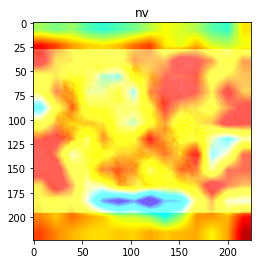

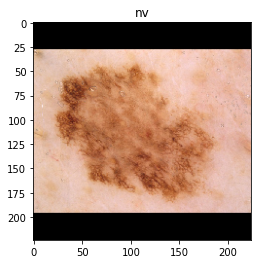

In [27]:
output_image = cv2.addWeighted(cv2.cvtColor(img[0].astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

print(CLASS_INDEX, lookup_lables[CLASS_INDEX] ,'predict--->' , pred_class, pred_class_name)

plt.title(pred_class_name)
plt.imshow(output_image)
plt.show()

img2 = tf.keras.preprocessing.image.load_img(IMG_PATH, target_size=(224,224))
plt.title(lookup_lables[CLASS_INDEX])
plt.imshow(img2)